# Jagawana - Forest Logging Detection

### 
<div class="alert alert-block alert-success"> 📌 This notebook is created for a capstone project, we are creating a Forest Logging Detection System to identify Chainsaws and Gunshots from forest ambiance sounds.</div>

### Workflow Problem Definition
Forests are huge and the terrain is hard to pass through, on the other side, forest ranger usually comprises of only several people. Often, rangers are patrolling the forest area for 1–2 weeks in a month, which means there are many opportunities for illegal loggers to get in and out without any patrol. This gap hole could be prevented by incorporating technology for the ranger and forests.

Jagawana is a Wide Sensor Network System deployed in the forests to prevent Ilegal Logging. By using sensors to pick up voices in the forests, we could monitor what happened in the forest in real-time. We deployed a Machine Learning Model to process the sounds taken by the sensor, then the model will identify the sounds into various categories, such as chainsaws, trucks, gunshot, and burning sounds.
   
### Workflow Goals
Our Machine Learning Model main goals is to **Classifying Forests Ambience Sounds**. We may want to classify or categorize sounds taken by our sensors. Our priority is to identify chainsaw sounds and alert users from Android App. Though categorizing other sounds is as important to map out fauna habitats, and for further research data.

### Workflow Stages :
This notebook workflow goes through seven stages.
1. Acquire training and testing data.
2. Wrangle, prepare, cleanse the data.
3. Analyze, identify patterns, and explore the data.
4. Model, predict and solve the problem.
5. Visualize, report, and present the problem solving steps and final solution.
6. Exporting Models

### Resources and References
* We use ESC-50 datasets for early development, using VGG-16 Models as our baseline and slightly adjust it for audio classification.
* Papers papers papers

<div class="alert alert-block alert-warning"> 📌 This project is still on development, feel free to comment or contact me through link in profile.</div>

# <center> Acquire Training and Testing Data </center>

In [17]:
# Library
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import IPython
import sklearn
import seaborn as sns
from sklearn.utils import shuffle

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [14]:
#This notebook use ESC-50 datasets on Kaggle Kernel, follow the step on README for further instructions.
CSV_FILE_PATH = "../input/environmental-sound-classification-50/esc50.csv"  # path of csv file
DATA_PATH = "../input/environmental-sound-classification-50/audio/audio/16000/" # path to folder containing audio files
# Reading the CSV File
df = pd.read_csv(CSV_FILE_PATH)
df.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [15]:
# We are going to use only 10 classes for early development
df_10 = df[df['esc10']==True]
df_10 = df_10.drop(['esc10','src_file','take'], axis=1)

# We need to convert the classes into numbers so the model could process it
classes = df_10['category'].unique()
class_dict = {i:x for x,i in enumerate(classes)}
print(class_dict)
df_10['target'] = df_10['category'].map(class_dict)

# Creating sample of each classes
sample_df = df_10.drop_duplicates(subset=['target'])
sample_df = sample_df.drop(sample_df.index[4:10])
print(sample_df.head())

{'dog': 0, 'chainsaw': 1, 'crackling_fire': 2, 'helicopter': 3, 'rain': 4, 'crying_baby': 5, 'clock_tick': 6, 'sneezing': 7, 'rooster': 8, 'sea_waves': 9}
             filename  fold  target        category
0    1-100032-A-0.wav     1       0             dog
24  1-116765-A-41.wav     1       1        chainsaw
54   1-17150-A-12.wav     1       2  crackling_fire
55  1-172649-A-40.wav     1       3      helicopter


In [3]:
# Class Conf will save the settings we are going to use in this notebook
class conf:
    sr = 16000
    duration = 3
    hop_length = 340*duration
    fmin = 20
    fmax = sr // 2
    n_mels = 128
    n_fft = n_mels * 20
    samples = sr * duration
    epochs = 30

def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sr)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), 'constant')
    return y

def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sr,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    return spectrogram

def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sr, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()

# <center> Visualization </center>

In [ ]:
# Visualization of Soundwave
fig, ax = plt.subplots(4, figsize = (8, 6))
fig.suptitle('Sound Waves', fontsize=16)
color = ['#A300F9', '#4300FF', '#009DFF', '#00FFB0']
i=0
for row in sample_df.itertuples(): 
    signal , rate = librosa.load(DATA_PATH+ row[1], sr=conf.sr)
    librosa.display.waveplot(y = signal, sr = rate, color = color[i], ax=ax[i])
    ax[i].set_ylabel(classes[row[3]], fontsize=13)
    i +=1

In [ ]:
# Visualization of Mel Spectogram
fig, ax = plt.subplots(4, figsize = (8, 6))
fig.suptitle('Mel Spectogram', fontsize=16)
i=0
for row in sample_df.itertuples(): 
    signal , rate = librosa.load(DATA_PATH+ row[1], sr=conf.sr)
    mel_spec = audio_to_melspectrogram(conf, signal)
    librosa.display.specshow(mel_spec, sr = conf.sr, hop_length = conf.hop_length, x_axis = 'time', 
                         fmin=conf.fmin, fmax=conf.fmax, y_axis = 'mel', ax=ax[i])
    ax[i].set_ylabel(row[3], fontsize=13)
    i +=1

In [ ]:
# Visualization of MFCC Plot
fig, ax = plt.subplots(4, figsize = (8, 5))
fig.suptitle('MFCC', fontsize=16)
i=0
for row in sample_df.itertuples(): 
    signal , rate = librosa.load(DATA_PATH+ row[1], sr=16000)
    mfcc = librosa.feature.mfcc(signal , rate , n_mfcc=13, dct_type=3)
    ax[i].imshow(mfcc, cmap='rainbow',interpolation='nearest')
    ax[i].set_ylabel(row[3], fontsize=13)
    i +=1

print(np.array(mfcc).shape)

# <center> Modifying VGG16 Model </center>

In [ ]:
INPUTSHAPE = (128, 32, 1)
def create_model():
    created_model =  models.Sequential([
        layers.Conv2D(64 , (3,3),activation = 'relu',padding='same', input_shape = INPUTSHAPE),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2), strides=(2,2)),
        layers.Dropout(0.2),

        layers.Conv2D(128, (3,3), activation='relu',padding='same'),                      
        layers.BatchNormalization(),
        layers.Conv2D(128, (3,3), activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2), strides=(2,2)),
        layers.Dropout(0.2),

        layers.Conv2D(256, (3,3), activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.Conv2D(256, (3,3), activation='relu',padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2), strides=(2,2)),    
        layers.Dropout(0.2),

        layers.GlobalAveragePooling2D(),

        layers.Dense(256 , activation = 'relu'),
        layers.Dense(256 , activation = 'relu'),
        layers.Dense(len(classes) , activation = 'softmax')
    ])

    created_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=['acc'])
    return created_model

In [ ]:
# Our model summary
model = create_model()
print(model.summary())

In [ ]:
%mkdir "cpkt"
%mkdir "logs"
LOGDIR = "logs"
CPKT = "cpkt/"

#this callback is used to prevent overfitting.
callback_1 = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto',
    baseline=None, restore_best_weights=False
)

#this checkpoint saves the best weights of model at every epoch
callback_2 = tf.keras.callbacks.ModelCheckpoint(
    CPKT, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None
)

#this is for tensorboard
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=LOGDIR)

# <center> Training</center>

In [ ]:
# This function will create our training and validation dataset.
# The fold number will be used as our validation data, and the rest as the training data.
def preprocess(fold):
    x_train , y_train = [] , []
    x_val , y_val = [] , []
    
    train_df = df_10[df_10.fold != fold]
    val_df = df_10[df_10.fold == fold]
    
    for data in train_df.itertuples():
        sig , sr = librosa.load(DATA_PATH+data[1], sr=16000)
        #Creating three random 2 second clip from each audio file, to create more samples
        for i in range(4):
            sig_ = sig[i : int((i+2)+sr)]
            mel_spec = audio_to_melspectrogram(conf, sig_)
            x_train.append(mel_spec)
            y_train.append(data[3])

    for data in val_df.itertuples():
        sig , sr = librosa.load(DATA_PATH+data[1], sr=16000)
        #Creating three random 2 second clip from each audio file, to create more samples
        for i in range(4):
            sig_ = sig[i : int((i+2)+sr)]
            mel_spec = audio_to_melspectrogram(conf, sig_)
            x_val.append(mel_spec)
            y_val.append(data[3])
            
    # convert list to numpy array
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    
    x_val = np.array(x_val)
    y_val = np.array(y_val)

    #one-hot encoding the target
    y_train = tf.keras.utils.to_categorical(y_train , num_classes=len(classes))
    y_val = tf.keras.utils.to_categorical(y_val , num_classes=len(classes))

    # our tensorflow model takes input as (no_of_sample , height , width , channel).
    # here X has dimension (no_of_sample , height , width).
    # So, the below code will reshape it to (no_of_sample , height , width , 1).
    x_train, y_train = shuffle(x_train, y_train)
    x_val, y_val = shuffle(x_val, y_val)
    
    x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
    x_val = x_val.reshape(x_val.shape[0], x_val.shape[1], x_val.shape[2], 1)
    
    return (x_train, y_train, x_val, y_val)

#### More about Cross Validation : [Link](https://www.kaggle.com/dansbecker/cross-validation)

In [ ]:
num_folds = len(df_10.fold.unique())

#save the model history in a list after fitting so that we can plot later
model_history = []
metrics = []


# The training section will use k-fold cross validation, just as suggested by the dataset creator.
# Cross Validation training will make a more robust model and prevent bias on training.
for fold in range(1, num_folds+1):
    print('\n\nTraining fold', fold)
    print('*' * 20)
    
    x_train, y_train, x_val, y_val = preprocess(fold)
    model = create_model()
    history = model.fit(x_train,y_train ,
            validation_data=(x_val,y_val),
            epochs=conf.epochs,
            callbacks = [callback_1], verbose=2)
    eval_score = model.evaluate(x_val, y_val)
    print("Val Score: ",eval_score )
    model_history.append(history)
    metrics.append(eval_score)

# <center> Evaluation </center>

In [ ]:
# Each fold will have this amount of data
print("Training on ", len(x_train)," samples")
print("Evaluating on ", len(x_val)," samples")

sum_acc = 0
sum_loss = 0

# Evaluation Score
print("Results of training")
for fold in range(num_folds):
    print("Evaluation Score on Fold ", fold+1, " :", metrics[fold])
    sum_acc += metrics[fold-1][1]
    sum_loss += metrics[fold-1][0]

print("Average Eval Acc : ", sum_acc/num_folds)
print("Average Loss Acc : ", sum_loss/num_folds)

In [ ]:
color = ['black', 'red', 'green', 'blue', 'purple']
plt.figure(figsize=(15,5))
plt.title('Accuracies vs Epochs')
for fold in range(num_folds):
    label_name_train = 'Train Accuracy Fold ' + str(fold)
    label_name_val = 'Val Accuracy Fold ' + str(fold)
    plt.plot(model_history[fold].history['acc'], label=label_name_train, color=color[fold])
    #Uncomment to see Val Accuracy Plot
#     plt.plot(model_history[fold].history['val_acc'], label=label_name_val, color=color[fold], linestyle = "dashdot")

plt.legend()
plt.show()

# <center> Bonus Section </center>
#### <center> Unhide and uncomment the code section below to load my trained model </center> 

In [11]:
new_model = models.load_model('../input/chainsaw-testing/')

In [12]:
# Creating a confusion matrix to see the error occured
y_pred = new_model.predict(x_val)
confusion_matrix = sklearn.metrics.confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

ax = plt.subplot()
sns.heatmap(confusion_matrix, annot=True, cmap="YlGnBu", ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes, rotation='vertical'); ax.yaxis.set_ticklabels(classes, rotation='horizontal');

NameError: name 'x_val' is not defined

#### There are some audio files I inserted to my datasets, let's see how the model identify sounds in the audio.

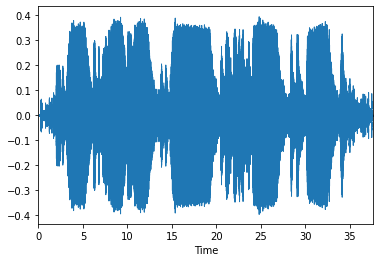

In [8]:
# The audio we are using is this one
import IPython.display as ipd
sig , sr = librosa.load('../input/chainsaw-testing/chainsaw-01.wav', sr=conf.sr)
ipd.display(ipd.Audio(sig, rate=sr))
librosa.display.waveplot(y = sig, sr = sr)

In [10]:
def split_audio(audio_data, w, h, threshold_level, tolerence=10):
    split_map = []
    start = 0
    data = np.abs(audio_data)
    threshold = threshold_level*np.mean(data[:25000])
    inside_sound = False
    near = 0
    for i in range(0,len(data)-w, h):
        win_mean = np.mean(data[i:i+w])
        if(win_mean>threshold and not(inside_sound)):
            inside_sound = True
            start = i
        if(win_mean<=threshold and inside_sound and near>tolerence):
            inside_sound = False
            near = 0
            split_map.append([start, i])
        if(inside_sound and win_mean<=threshold):
            near += 1
    return split_map

Clip Number : 1
Interval from :  3.125  to  6.875 seconds
Results :  chainsaw 

Clip Number : 2
Interval from :  7.65625  to  13.4375 seconds
Results : Unknown
Confidence Level :  [[3.34681936e-05 7.66973317e-01 1.03970324e-05 1.99533487e-03
  1.19249591e-04 2.16331050e-01 4.95612803e-05 5.91306452e-05
  1.43269645e-02 1.01539823e-04]]
Highest Confidence Level :  chainsaw  of  76.69733166694641 %



Clip Number : 3
Interval from :  14.84375  to  21.09375 seconds
Results :  chainsaw 

Clip Number : 4
Interval from :  21.875  to  26.875 seconds
Results :  chainsaw 

Clip Number : 5
Interval from :  30.0  to  34.21875 seconds
Results :  chainsaw 



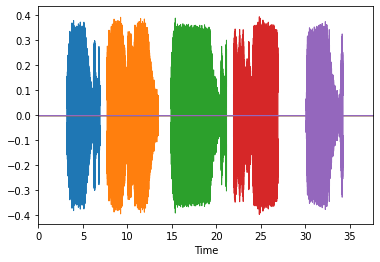

In [76]:
# To identify the sounds in the audio, we are going to cut the soundwave into several parts
# The clip will be clipped to it's highlight (noisiest) with certain interval

sound_clips = split_audio(sig, 10000, 2500, 15, 10)
duration = len(sig)
i = 1

for intvl in sound_clips:
    clip, index = librosa.effects.trim(sig[intvl[0]:intvl[1]],       
                                       top_db=20, frame_length=512, hop_length=64)
    mel_spec = audio_to_melspectrogram(conf, clip)
    testing = np.array(mel_spec)
    testing = testing.reshape(1, testing.shape[0], testing.shape[1], 1)
    pred = new_model.predict(testing)
    
    blank = np.zeros(intvl[0]-0)
    blank2 = np.zeros(duration-intvl[1])
    temp = np.append(blank,clip)
    temp = np.append(temp,blank2)
    librosa.display.waveplot(y = temp, sr = sr, )
    
    print("Clip Number :", i)
    print("Interval from : ", intvl[0]/16000, " to ",intvl[1]/16000, "seconds")
    i += 1
    if(pred.max() > 0.8):
        print("Results : ", classes[np.argmax(pred)], "\n")
    else:
        print("Results : Unknown")
        print("Confidence Level : ", pred)
        print("Highest Confidence Level : ", classes[np.argmax(pred)], " of ", np.max(pred)*100, "%\n")
        ipd.display(ipd.Audio(clip, rate=sr))

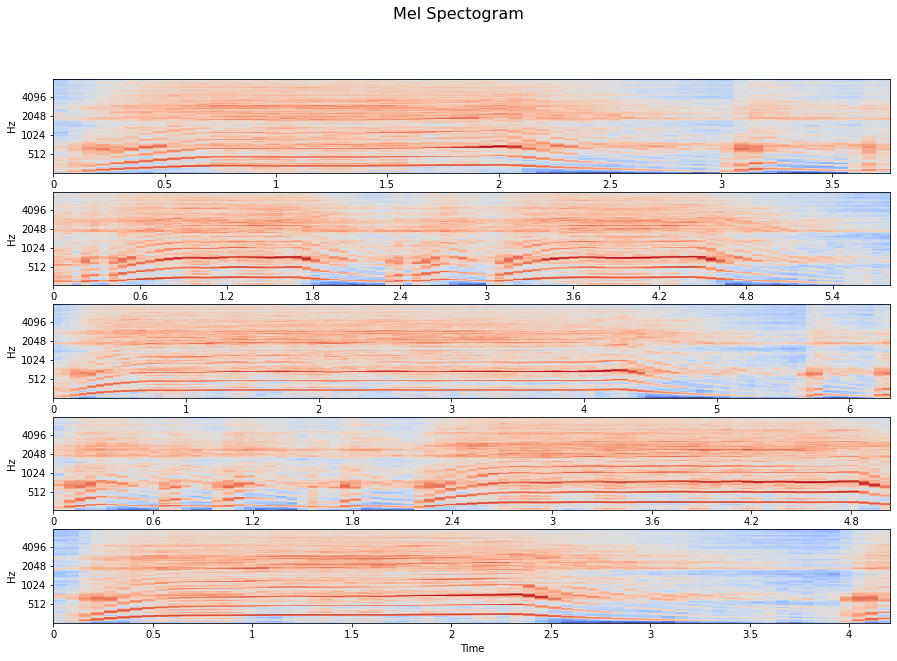

In [71]:
# Showing the Mel Spectogram that is passed to the model

fig, ax = plt.subplots(5, figsize = (15, 10))
fig.suptitle('Mel Spectogram', fontsize=16)
i=0
for intvl in sound_clips:
    clip, index = librosa.effects.trim(sig[intvl[0]:intvl[1]],       
                                       top_db=20, frame_length=512, hop_length=64)
    mel_spec = audio_to_melspectrogram(conf, clip)
    librosa.display.specshow(mel_spec, sr = conf.sr, hop_length = conf.hop_length, x_axis = 'time', 
                         fmin=conf.fmin, fmax=conf.fmax, y_axis = 'mel', ax=ax[i])
    i +=1

# <center> Saving Model </center>

In [ ]:
# Uncomment code below to save the model to folder "/kaggle/working/export"
# The exported model will be on SavedModel Tensorflow format, which is the default for Tensorflow 2.% model

# model.save("export")